<a href="https://colab.research.google.com/github/tcapelle/solar_seg/blob/master/Solar_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import fastai
from fastai.vision import *

In [2]:
from fastai.utils.show_install import *
show_install()



```text
=== Software === 
python       : 3.7.2
fastai       : 1.0.42
fastprogress : 0.1.18
torch        : 1.0.0
torch cuda   : None / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : Darwin-14.5.0-x86_64-i386-64bit
conda env    : solar
python       : /Users/thomascapelle/anaconda3/envs/solar/bin/python
sys.path     : /Users/thomascapelle/SolarImages
/Users/thomascapelle/anaconda3/envs/solar/lib/python37.zip
/Users/thomascapelle/anaconda3/envs/solar/lib/python3.7
/Users/thomascapelle/anaconda3/envs/solar/lib/python3.7/lib-dynload

/Users/thomascapelle/anaconda3/envs/solar/lib/python3.7/site-packages
/Users/thomascapelle/anaconda3/envs/solar/lib/python3.7/site-packages/IPython/extensions
/Users/thomascapelle/.ipython
no supported gpus found on this system
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.



In [3]:
!git clone https://github.com/tcapelle/solar_seg/

fatal: destination path 'solar_seg' already exists and is not an empty directory.


In [5]:
path = Path('./')
path_lbl = path/'masks'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('images/00000.png'),
 PosixPath('images/00001.png'),
 PosixPath('images/00002.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('masks/00000.png'),
 PosixPath('masks/00001.png'),
 PosixPath('masks/00002.png')]

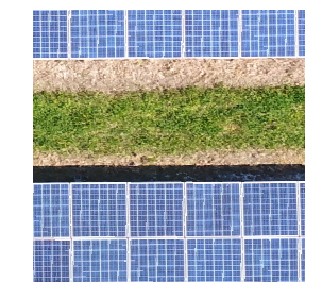

In [14]:
img_f = fnames[807]
img = open_image(img_f)
img.show(figsize=(5,5))

In [15]:
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

In [16]:
get_y_fn(img_f)

PosixPath('masks/00807.png')

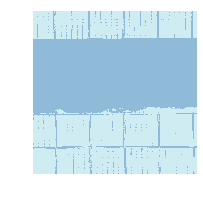

In [42]:
mask = open_mask(get_y_fn(img_f))
mask.show()

In [41]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([256, 256]), tensor([[[255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          ...,
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255],
          [255, 255, 255,  ..., 255, 255, 255]]]))

In [19]:
size = src_size//2
bs=1

In [30]:
src = (SegmentationItemList.from_folder(path_img)
       .random_split_by_pct()
       .label_from_func(get_y_fn, classes=['background','solar_module']))

In [31]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [32]:
data

ImageDataBunch;

Train: LabelList
y: SegmentationLabelList (2756 items)
[ImageSegment (1, 256, 256), ImageSegment (1, 256, 256), ImageSegment (1, 256, 256), ImageSegment (1, 256, 256), ImageSegment (1, 256, 256)]...
Path: images
x: SegmentationItemList (2756 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: images;

Valid: LabelList
y: SegmentationLabelList (688 items)
[ImageSegment (1, 256, 256), ImageSegment (1, 256, 256), ImageSegment (1, 256, 256), ImageSegment (1, 256, 256), ImageSegment (1, 256, 256)]...
Path: images
x: SegmentationItemList (688 items)
[Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256), Image (3, 256, 256)]...
Path: images;

Test: None

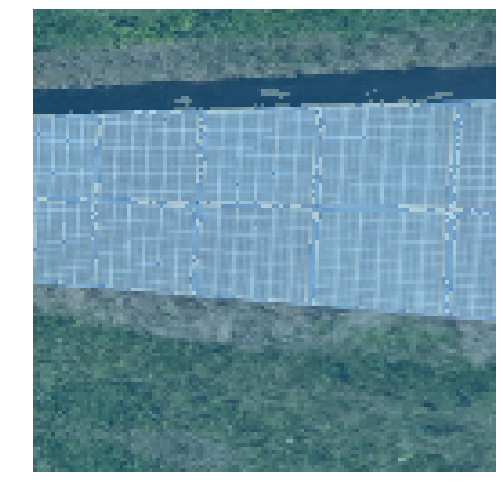

In [33]:
data.show_batch(2, figsize=(10,7))

In [23]:
metrics = partial(dice, iou=True)
wd = 1e-2

In [24]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [25]:
learn.lr_find(); learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


RuntimeError: Assertion `cur_target >= 0 && cur_target < n_classes' failed.  at /Users/administrator/nightlies/pytorch-1.0.0/wheel_build_dirs/conda_3.7/conda/conda-bld/pytorch_1544144746443/work/aten/src/THNN/generic/ClassNLLCriterion.c:93